In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2

In [2]:
IMAGES_PATH = "images"

In [3]:
def draw_landmarks_on_image(rgb_image, detection_result):
    face_landmarks_list = detection_result.face_landmarks
    annotated_image = np.copy(rgb_image)
    
    landmarks_points = []

    # Loop through the detected faces to visualize.
    for idx in range(len(face_landmarks_list)):
        face_landmarks = face_landmarks_list[idx]

        for f_landmark in face_landmarks:
            landmarks_points.append((f_landmark.x*rgb_image.shape[1],f_landmark.y*rgb_image.shape[0]))

        # Draw the face landmarks.
        face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        face_landmarks_proto.landmark.extend([
          landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
        ])
    
		# triangles
        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp.solutions.drawing_styles
            .get_default_face_mesh_tesselation_style())
        # eye - eyebrows
        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp.solutions.drawing_styles
            .get_default_face_mesh_contours_style())
        # iris
        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_IRISES,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp.solutions.drawing_styles
            .get_default_face_mesh_iris_connections_style())
  
    return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
    # Extract the face blendshapes category names and scores.
    face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
    face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
    # The blendshapes are ordered in decreasing score value.
    face_blendshapes_ranks = range(len(face_blendshapes_names))
  
    _, ax = plt.subplots(figsize=(12, 12))
    bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
    ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
    ax.invert_yaxis()
  
    # Label each bar with values
    for score, patch in zip(face_blendshapes_scores, bar.patches):
        plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")
  
    ax.set_xlabel('Score')
    ax.set_title("Face Blendshapes")
    plt.tight_layout()
    plt.show()

def get_landmark_points(face_landmarks, img):
    landmarks_points = []
    for f_landmark in face_landmarks:
        landmarks_points.append((f_landmark.x*img.shape[1],
                                 f_landmark.y*img.shape[0]))
    
    return landmarks_points

def get_index_triangles(points, triangles):
    indexes_triangles = []
    for t in triangles:
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])

        index_pt1 = np.where((points == pt1).all(axis=1))[0][0]
        index_pt2 = np.where((points == pt2).all(axis=1))[0][0]
        index_pt3 = np.where((points == pt3).all(axis=1))[0][0]

        if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
            indexes_triangles.append([index_pt1, index_pt2, index_pt3])
    
    return indexes_triangles

def triangulation(landmarks_points, triangle_index):
    tr_pt1 = landmarks_points[triangle_index[0]]
    tr_pt2 = landmarks_points[triangle_index[1]]
    tr_pt3 = landmarks_points[triangle_index[2]]
    triangle = np.array([tr_pt1, tr_pt2, tr_pt3], np.int32)
    rect1 = cv.boundingRect(triangle)
    (x, y, w, h) = rect1
    cropped_tr_mask = np.zeros((h, w), np.uint8)


    points = np.array([[tr_pt1[0] - x, tr_pt1[1] - y],
                        [tr_pt2[0] - x, tr_pt2[1] - y],
                        [tr_pt3[0] - x, tr_pt3[1] - y]], np.int32)

    cv.fillConvexPoly(cropped_tr_mask, points, 255)
    
    return (x, y, w, h), cropped_tr_mask, np.float32(points)

def face_to_swap(img1, detection_result1, img2, detection_result2):
    try:
        # Face 1 (to swap)
        img_gray1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
        mask = np.zeros_like(img_gray1)
        face_landmarks1 = detection_result1.face_landmarks[0]

        landmarks_points1 = get_landmark_points(face_landmarks1, img1)

        points = np.array(landmarks_points1, np.int32)
        convexhull = cv.convexHull(points)
        cv.fillConvexPoly(mask, convexhull, 255)

	    # Delaunay triangulation
        rect = cv.boundingRect(convexhull)
        subdiv = cv.Subdiv2D(rect)
        subdiv.insert(landmarks_points1)
        triangles =  np.array(subdiv.getTriangleList(), dtype=np.int32)
        indexes_triangles = get_index_triangles(points, triangles)

        # Face 2 (dest)
        annotated_image2_gray = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
        face_landmarks2 = detection_result2.face_landmarks[0]
        height, width, channels = img2.shape
        img2_new_face = np.zeros((height, width, channels), np.uint8)  
        landmarks_points2 = get_landmark_points(face_landmarks2, img2)

        points2 = np.array(landmarks_points2, np.int32)
        convexhull2 = cv.convexHull(points2)

        for triangle_index in indexes_triangles:
            # Triangulation of the first face
            (x, y, w, h), cropped_tr1_mask1, points1 = triangulation(landmarks_points1, triangle_index)
            cropped_triangle = img1[y: y + h, x: x + w]

            # Triangulation of second face
            (x, y, w, h), cropped_tr2_mask, points2 = triangulation(landmarks_points2, triangle_index)

            # Warp triangles
            M = cv.getAffineTransform(points1, points2)
            warped_triangle = cv.warpAffine(cropped_triangle, M, (w, h))
            warped_triangle = cv.bitwise_and(warped_triangle, warped_triangle, mask=cropped_tr2_mask)

            # Reconstructing destination face
            img2_new_face_rect_area = img2_new_face[y: y + h, x: x + w]
            img2_new_face_rect_area_gray = cv.cvtColor(img2_new_face_rect_area, cv.COLOR_BGR2GRAY)
            _, mask_triangles_designed = cv.threshold(img2_new_face_rect_area_gray, 1, 255, cv.THRESH_BINARY_INV)
            warped_triangle = cv.bitwise_and(warped_triangle, warped_triangle, mask=mask_triangles_designed)

            img2_new_face_rect_area = cv.add(img2_new_face_rect_area, warped_triangle)
            img2_new_face[y: y + h, x: x + w] = img2_new_face_rect_area
    except: 
        return img2
    
    # Face swapped (putting 1st face into 2nd face)
    img2_face_mask = np.zeros_like(annotated_image2_gray)
    img2_head_mask = cv.fillConvexPoly(img2_face_mask, convexhull2, 255)
    img2_face_mask = cv.bitwise_not(img2_head_mask)

    img2_head_noface = cv.bitwise_and(img2, img2, mask=img2_face_mask)
    result = cv.add(img2_head_noface, img2_new_face)

    (x, y, w, h) = cv.boundingRect(convexhull2)
    center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))

    output = cv.seamlessClone(result, img2, img2_head_mask, center_face2, cv.NORMAL_CLONE)

    return output

c:\Users\nicol\miniconda3\envs\ia\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


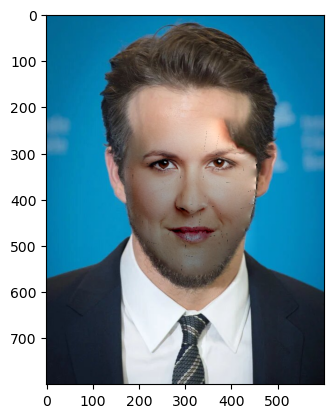

In [4]:
BaseOptions = mp.tasks.BaseOptions
FaceLandmarker = mp.tasks.vision.FaceLandmarker
FaceLandmarkerOptions = mp.tasks.vision.FaceLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

options = FaceLandmarkerOptions(
    base_options=BaseOptions(model_asset_path="model/face_landmarker.task"),
    running_mode=VisionRunningMode.IMAGE)

with FaceLandmarker.create_from_options(options) as landmarker:

    # The landmarker is initialized. Use it here.
    # Load the input image from an image file.
    mp_image1 = mp.Image.create_from_file(f"{IMAGES_PATH}/business_girl.png")
    mp_image2 = mp.Image.create_from_file(f"{IMAGES_PATH}/ryan_reynolds.jpg")

    # Perform face landmarking on the provided single image.
    # The face landmarker must be created with the image mode.
    face_landmarker_result1 = landmarker.detect(mp_image1)    
    face_landmarker_result2 = landmarker.detect(mp_image2)    

    output = face_to_swap(mp_image1.numpy_view(), face_landmarker_result1,
                          mp_image2.numpy_view(), face_landmarker_result2)
    
    plt.imshow(output)